# Economic Trend Analysis (2000–2024)

This project explores key economic indicators such as GDP, Federal Funds Rate, S&P500, Median CPI, and Unemployment Rate. 

## **Goals:**
1. Data Cleaning and Preprocessing: Prepare the dataset by handling missing values and ensuring data consistency.
2. Exploratory Data Analysis (EDA): Analyze the economic indicators to identify trends and relationships.
3. Predictive and Clustering Models: Build models to forecast future economic trends and group similar periods.
4. Data Visualization: Create visual representations to highlight key insights and patterns.
5. Dashboard Development: Develop an interactive dashboard to present the analysis and findings.

## Import Libraries and Load Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout



In [2]:
# Define file paths for datasets
files = {
    "Federal_Funds_Rate": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\Federal Funds Effective Rate.csv",
    "GDP": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\GDP.csv",
    "Median_CPI": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\Median CPI.csv",
    "S&P500": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\sp500 yahoo.csv",
    "Unemployment_Rate": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\unemployment_rate.csv"
}

# Load datasets into a dictionary of DataFrames
datasets = {name: pd.read_csv(path) for name, path in files.items()}


In [3]:
# Rename and standardize column names
datasets["Federal_Funds_Rate"].rename(columns={"DFF": "FEDERAL_FUNDS_RATE"}, inplace=True)
datasets["GDP"].rename(columns={"GDP": "GROSS_DOMESTIC_PRODUCT"}, inplace=True)
datasets["Median_CPI"].rename(columns={"MEDCPIM158SFRBCLE": "MEDIAN_CPI"}, inplace=True)
datasets["S&P500"].rename(columns={"Close": "SP500_CLOSE"}, inplace=True)
datasets["Unemployment_Rate"].rename(columns={"UNRATE": "UNEMPLOYMENT_RATE"}, inplace=True)

# Clean each dataset
for name, df in datasets.items():
    df.columns = df.columns.str.upper().str.strip()
    if 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df.interpolate(method='linear', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)


### Save Cleaned Data into SQLite



In [4]:
# Save cleaned datasets into SQLite database
conn = sqlite3.connect('Economic_Analysis.db')
for name, df in datasets.items():
    table_name = name.replace(" ", "_").replace("&", "_").upper()
    df.to_sql(table_name, conn, if_exists='replace', index=False)


## Merge Data for Analysis

In [5]:
# Query to merge all datasets
query = '''
    SELECT 
        a.DATE,
        a.FEDERAL_FUNDS_RATE,
        b.GROSS_DOMESTIC_PRODUCT,
        c.MEDIAN_CPI,
        d.SP500_CLOSE,
        e.UNEMPLOYMENT_RATE
    FROM FEDERAL_FUNDS_RATE a
    JOIN GDP b ON a.DATE = b.DATE
    JOIN MEDIAN_CPI c ON a.DATE = c.DATE
    JOIN S_P500 d ON a.DATE = d.DATE
    JOIN UNEMPLOYMENT_RATE e ON a.DATE = e.DATE
'''

# Load merged dataset into DataFrame
merged_df = pd.read_sql_query(query, conn)
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')
merged_df['SP500_CLOSE'] = merged_df['SP500_CLOSE'].str.replace(',', '').astype(float)


### Summary Statistics

In [6]:
# Display summary statistics
print("Summary Statistics for Merged Data:")
print(merged_df.describe())


Summary Statistics for Merged Data:
                      DATE  FEDERAL_FUNDS_RATE  GROSS_DOMESTIC_PRODUCT  \
count                   48           48.000000               48.000000   
mean   2012-03-01 05:00:00            0.989583            16823.184187   
min    2001-10-01 00:00:00            0.060000            10660.465000   
25%    2007-03-09 12:00:00            0.107500            14071.587500   
50%    2012-02-15 00:00:00            0.265000            16034.049500   
75%    2017-01-22 12:00:00            1.852500            19153.340250   
max    2022-07-01 00:00:00            4.920000            26272.011000   
std                    NaN            1.139817             4256.683574   

       MEDIAN_CPI  SP500_CLOSE  UNEMPLOYMENT_RATE  
count   48.000000    48.000000          48.000000  
mean     2.567626  1892.952500           6.422917  
min      0.125833   811.080000           3.500000  
25%      1.982906  1132.002500           5.075000  
50%      2.359403  1495.765000       

## Exploratory Data Analysis (EDA)




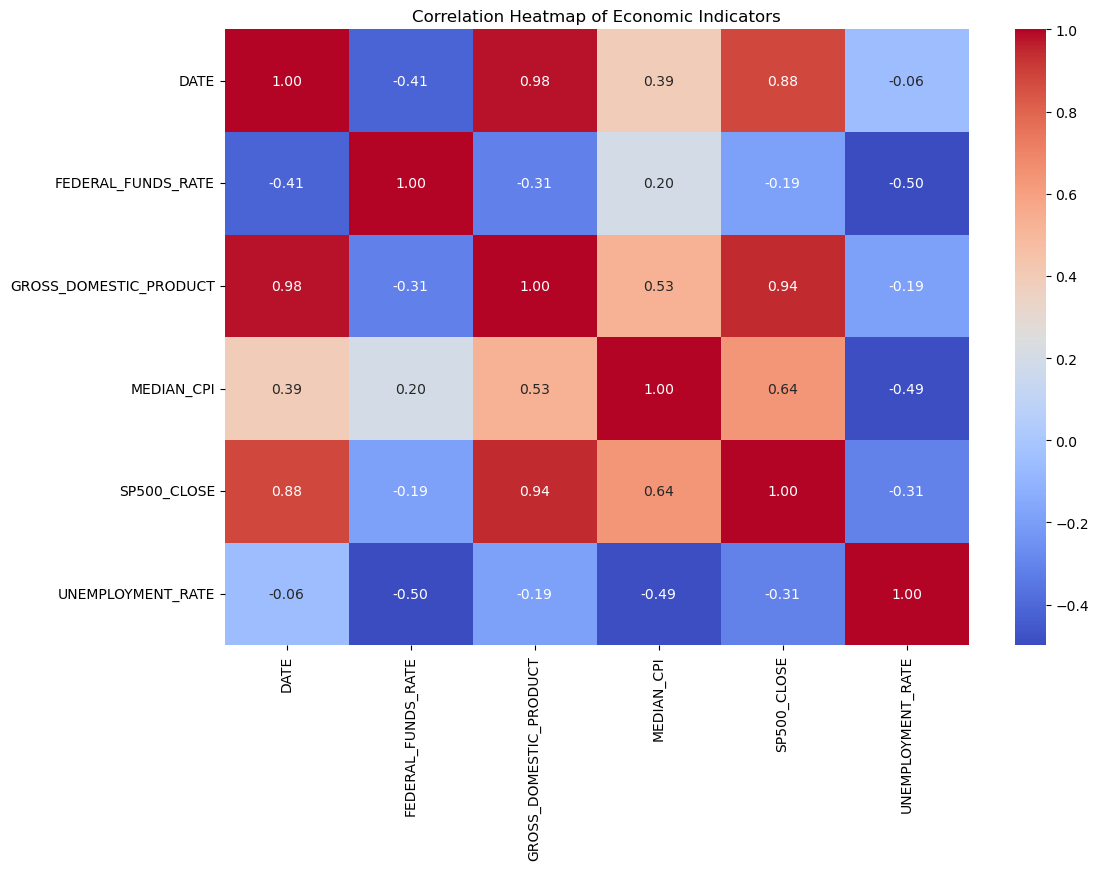

In [7]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()


### Time Series Decomposition

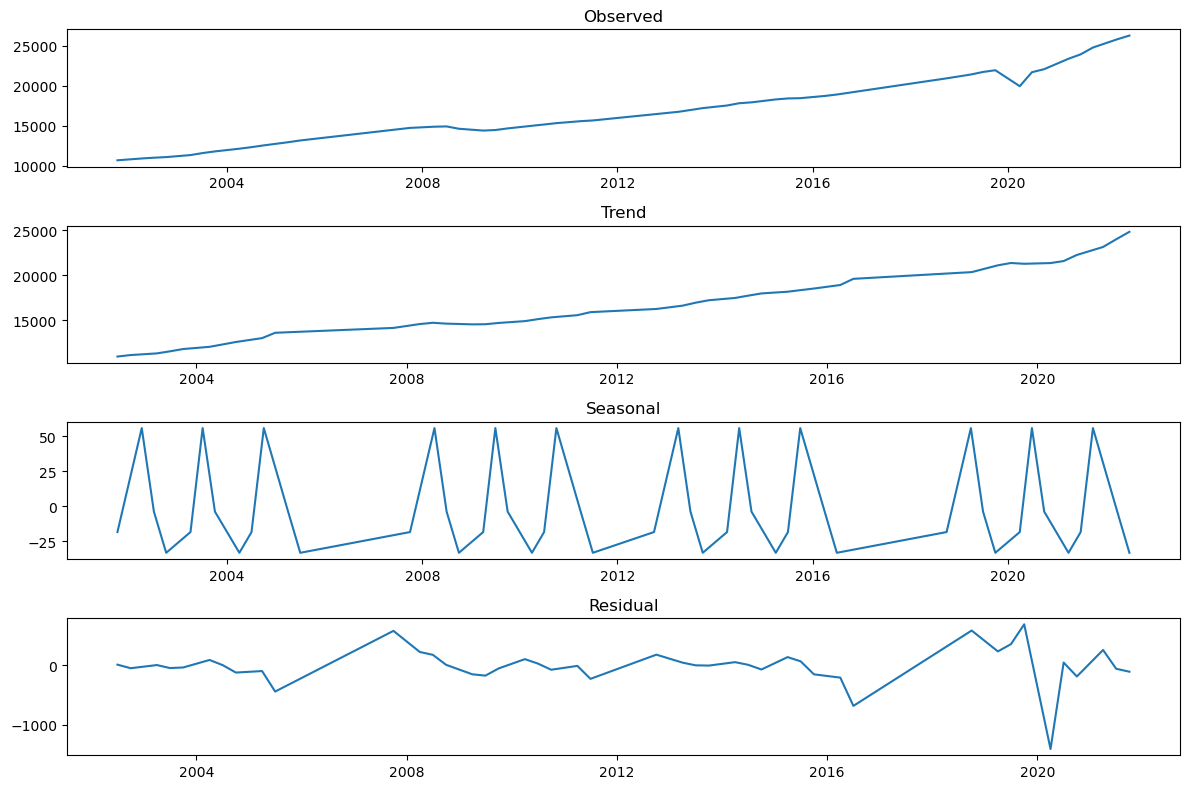

In [8]:
# Time-Series Decomposition for GDP
gdp_series = merged_df.set_index('DATE')['GROSS_DOMESTIC_PRODUCT']
decomposition = seasonal_decompose(gdp_series, model='additive', period=4)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1); plt.plot(decomposition.observed); plt.title("Observed")
plt.subplot(4, 1, 2); plt.plot(decomposition.trend); plt.title("Trend")
plt.subplot(4, 1, 3); plt.plot(decomposition.seasonal); plt.title("Seasonal")
plt.subplot(4, 1, 4); plt.plot(decomposition.resid); plt.title("Residual")
plt.tight_layout()
plt.show()



### Clustering Analysis

C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


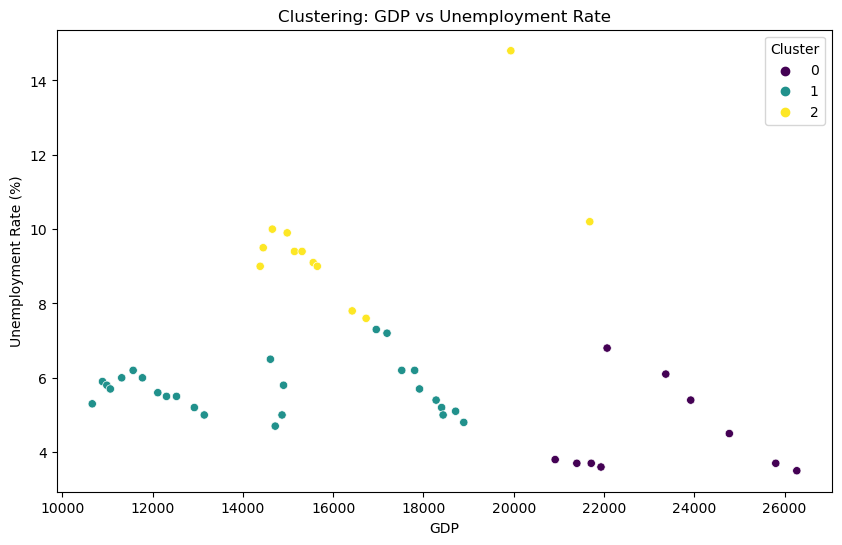

In [9]:
# Clustering Analysis
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[['GROSS_DOMESTIC_PRODUCT', 'UNEMPLOYMENT_RATE', 'SP500_CLOSE']])

# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Scatter Plot for Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_df, 
    x='GROSS_DOMESTIC_PRODUCT', 
    y='UNEMPLOYMENT_RATE', 
    hue='Cluster', 
    palette='viridis'
)
plt.title("Clustering: GDP vs Unemployment Rate")
plt.xlabel("GDP")
plt.ylabel("Unemployment Rate (%)")
plt.legend(title='Cluster')
plt.show()


### Predictive Modeling 


In [10]:
# Prepare features and target
X = merged_df[['FEDERAL_FUNDS_RATE', 'MEDIAN_CPI', 'SP500_CLOSE', 'UNEMPLOYMENT_RATE']]
y = merged_df['GROSS_DOMESTIC_PRODUCT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ensemble Model
ensemble_model = VotingRegressor([
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42)),
    ('LinearRegression', LinearRegression())
])
ensemble_model.fit(X_train, y_train)

# Evaluate Ensemble Model
y_pred = ensemble_model.predict(X_test)
print("Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")


Ensemble Model Performance:
MAE: 773.6578351193579
MSE: 739099.2159720274
RMSE: 859.7087971935773


### Budget and Economic Indicator Analysis

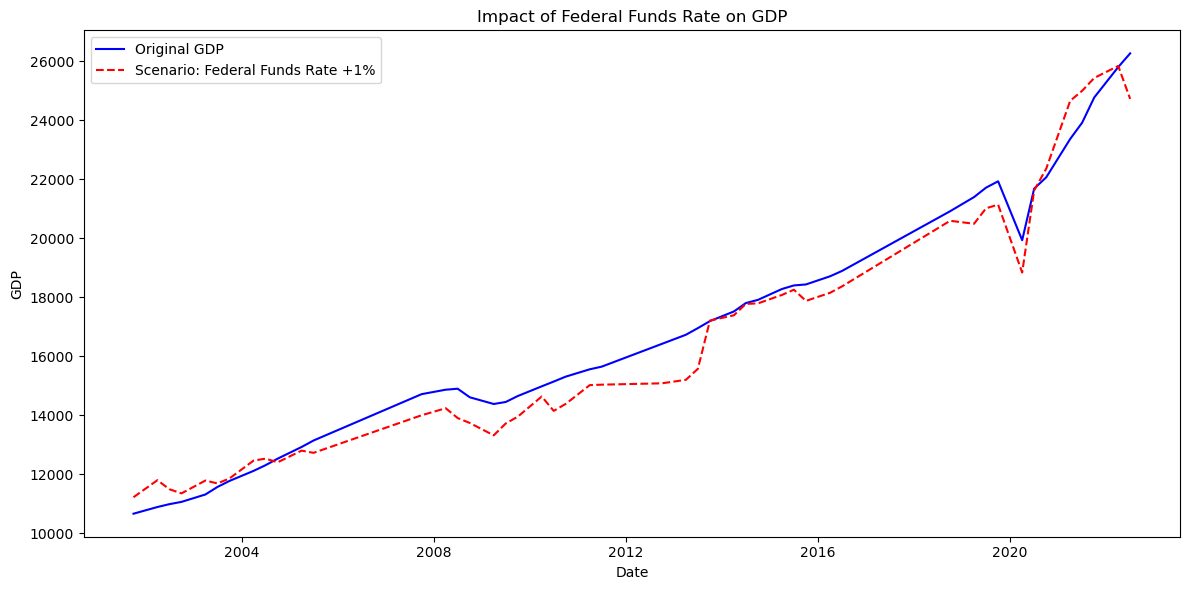

In [11]:
# Simulate the impact of a 1% increase in Federal Funds Rate
scenario = merged_df.copy()
scenario['FEDERAL_FUNDS_RATE'] += 1  # Simulate 1% increase
scenario_pred = ensemble_model.predict(scenario[['FEDERAL_FUNDS_RATE', 'MEDIAN_CPI', 'SP500_CLOSE', 'UNEMPLOYMENT_RATE']])

# Compare Scenarios
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GROSS_DOMESTIC_PRODUCT'], label='Original GDP', color='blue')
plt.plot(merged_df['DATE'], scenario_pred, label='Scenario: Federal Funds Rate +1%', linestyle='--', color='red')

plt.title("Impact of Federal Funds Rate on GDP")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.tight_layout()
plt.show()


### Rolling Correlation Analysis

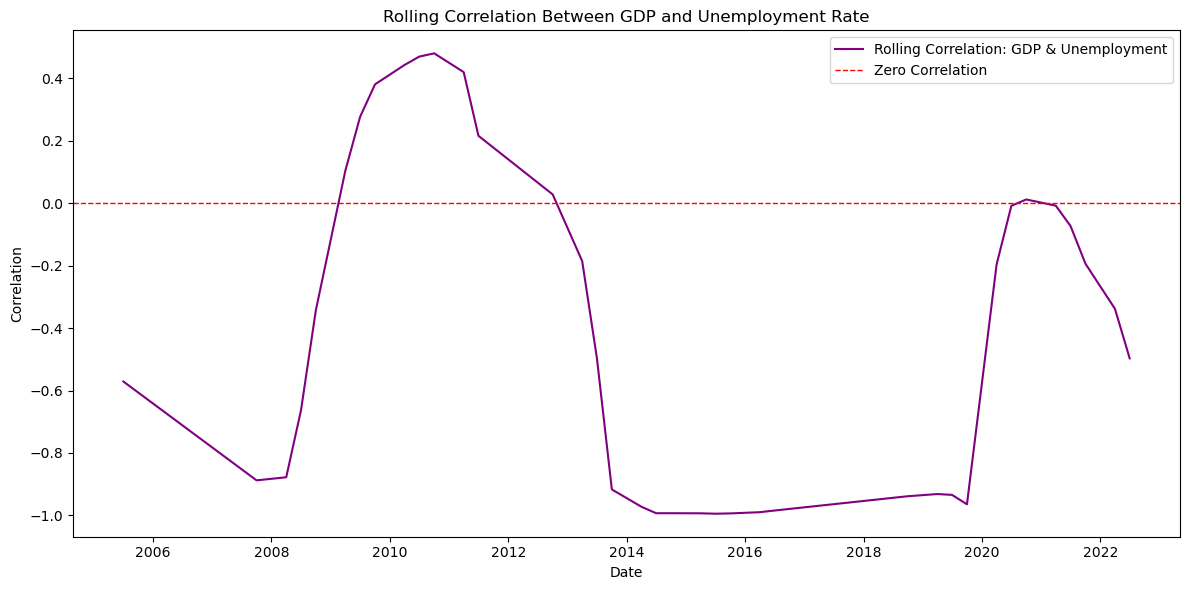

In [12]:
# Calculate rolling correlation between GDP and Unemployment Rate
merged_df['GDP_UNEMPLOYMENT_ROLLING_CORR'] = merged_df['GROSS_DOMESTIC_PRODUCT'].rolling(window=12).corr(merged_df['UNEMPLOYMENT_RATE'])

# Plot Rolling Correlation
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GDP_UNEMPLOYMENT_ROLLING_CORR'], label="Rolling Correlation: GDP & Unemployment", color='purple')
plt.axhline(0, linestyle='--', color='red', linewidth=1, label='Zero Correlation')

plt.title("Rolling Correlation Between GDP and Unemployment Rate")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()
plt.show()


### Highlight Recovery Periods

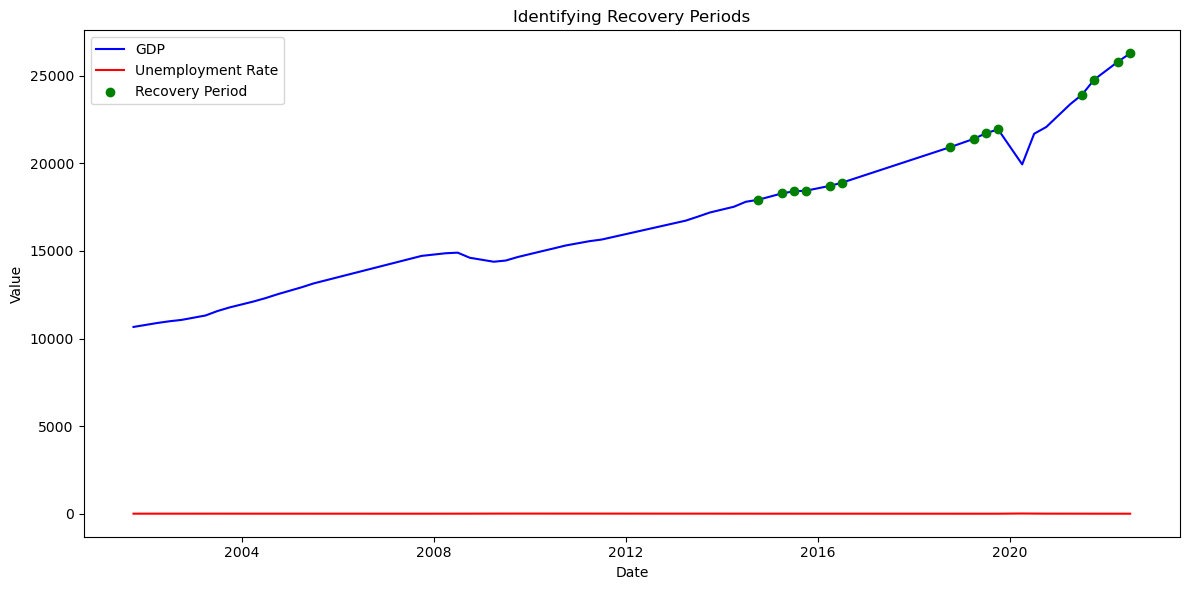

In [13]:
# Highlight periods of economic recovery
recovery_periods = merged_df[(merged_df['UNEMPLOYMENT_RATE'] < 6) & (merged_df['GROSS_DOMESTIC_PRODUCT'] > 15000)]

# Plot GDP and Unemployment for recovery analysis
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GROSS_DOMESTIC_PRODUCT'], label='GDP', color='blue')
plt.plot(merged_df['DATE'], merged_df['UNEMPLOYMENT_RATE'], label='Unemployment Rate', color='red')
plt.scatter(recovery_periods['DATE'], recovery_periods['GROSS_DOMESTIC_PRODUCT'], color='green', label='Recovery Period', zorder=5)

plt.title("Identifying Recovery Periods")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


### Financial Forecasting with ARIMA

C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

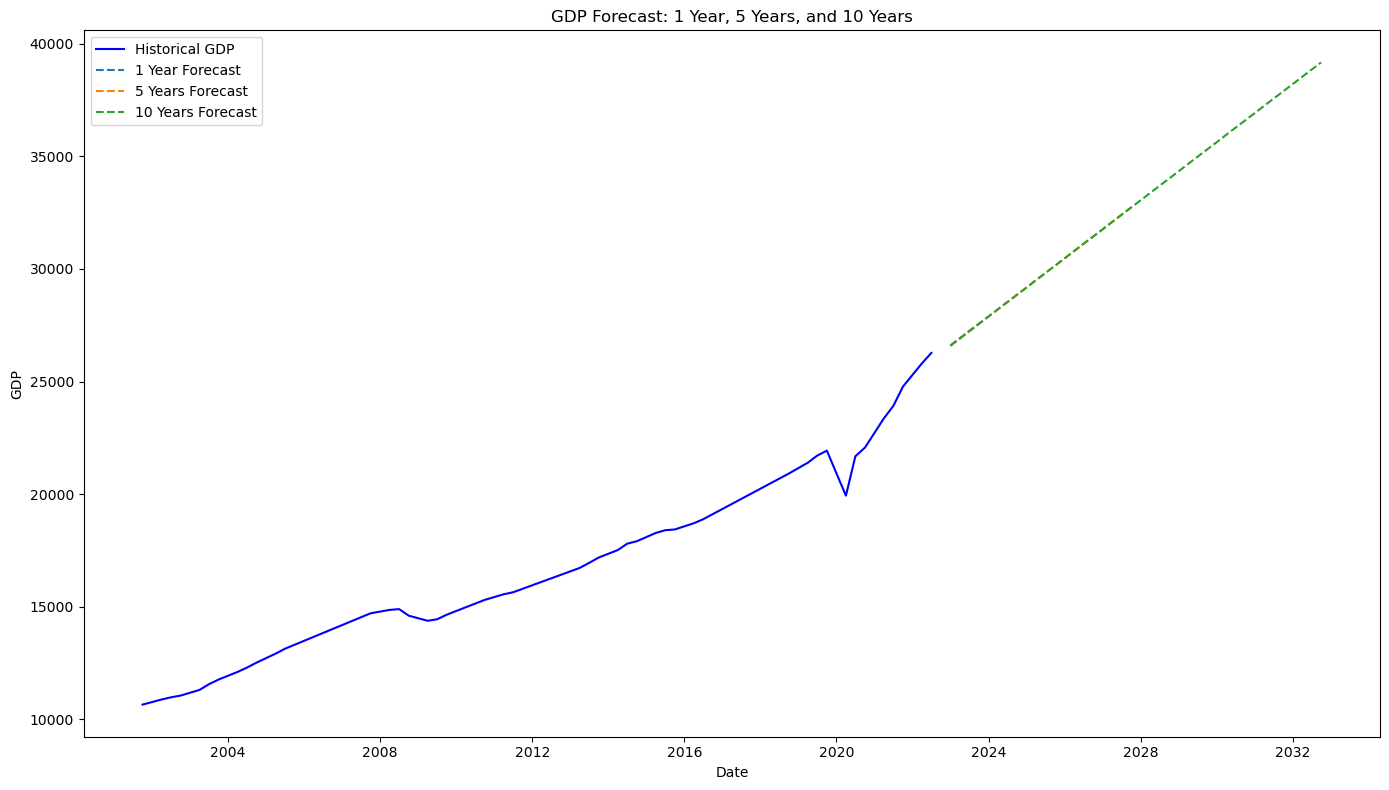


1 Year Forecast:
         Date  Projected GDP
48 2022-12-31   26594.398067
49 2023-03-31   26916.782940
50 2023-06-30   27239.165619
51 2023-09-30   27561.546105

5 Years Forecast:
         Date  Projected GDP
48 2022-12-31   26594.398067
49 2023-03-31   26916.782940
50 2023-06-30   27239.165619
51 2023-09-30   27561.546105
52 2023-12-31   27883.924398
53 2024-03-31   28206.300497
54 2024-06-30   28528.674402
55 2024-09-30   28851.046114
56 2024-12-31   29173.415633
57 2025-03-31   29495.782958
58 2025-06-30   29818.148089
59 2025-09-30   30140.511028
60 2025-12-31   30462.871773
61 2026-03-31   30785.230324
62 2026-06-30   31107.586682
63 2026-09-30   31429.940847
64 2026-12-31   31752.292818
65 2027-03-31   32074.642596
66 2027-06-30   32396.990181
67 2027-09-30   32719.335573

10 Years Forecast:
         Date  Projected GDP
48 2022-12-31   26594.398067
49 2023-03-31   26916.782940
50 2023-06-30   27239.165619
51 2023-09-30   27561.546105
52 2023-12-31   27883.924398
53 2024-03-31  

In [14]:
# ARIMA Long-Term Forecasting for GDP
gdp_series = merged_df.set_index('DATE')['GROSS_DOMESTIC_PRODUCT']

# Fit ARIMA model
arima_model = ARIMA(gdp_series, order=(1, 1, 1))  # Adjust order as needed
arima_fit = arima_model.fit()

# Forecast for 1 year, 5 years, and 10 years
forecast_horizons = {'1 Year': 4, '5 Years': 20, '10 Years': 40}
forecasts = {}
forecast_dates = {}

for label, steps in forecast_horizons.items():
    forecasts[label] = arima_fit.forecast(steps=steps)
    forecast_dates[label] = pd.date_range(
        start=gdp_series.index[-1], 
        periods=steps + 1, 
        freq='Q'
    )[1:]

# Plot historical data and forecasts
plt.figure(figsize=(14, 8))
plt.plot(gdp_series.index, gdp_series, label='Historical GDP', color='blue')

# Add forecasts to the plot
for label in forecast_horizons.keys():
    plt.plot(forecast_dates[label], forecasts[label], label=f'{label} Forecast', linestyle='--')

plt.title("GDP Forecast: 1 Year, 5 Years, and 10 Years")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.tight_layout()
plt.show()

# Print the forecasted values for each horizon
for label in forecast_horizons.keys():
    forecast_df = pd.DataFrame({'Date': forecast_dates[label], 'Projected GDP': forecasts[label]})
    print(f"\n{label} Forecast:")
    print(forecast_df)


###  LSTM Time-Series Forecasting

In [15]:
# Time-Series Forecasting with LSTM

# Scale only the GDP column
gdp_series = merged_df[['DATE', 'GROSS_DOMESTIC_PRODUCT']].set_index('DATE').sort_index()
gdp_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_gdp = gdp_scaler.fit_transform(gdp_series)

# Create sequences for LSTM
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 12
X_lstm, y_lstm = create_sequences(scaled_gdp, time_steps)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

# Train LSTM Model
lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=16, verbose=1)

# Forecast with LSTM
forecast_input = scaled_gdp[-time_steps:]
forecast_input = forecast_input.reshape((1, time_steps, 1))
forecast = []

for _ in range(12):
    # Predict the next value
    prediction = lstm_model.predict(forecast_input)
    forecast.append(prediction[0, 0])  # Extract the predicted value

    # Reshape prediction to match forecast_input dimensions
    prediction_reshaped = prediction.reshape((1, 1, 1))

    # Update forecast_input by appending the prediction
    forecast_input = np.append(forecast_input[:, 1:, :], prediction_reshaped, axis=1)

# Inverse scale the predictions using the GDP scaler
forecast = gdp_scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

print("LSTM Forecasted GDP for the next 12 months:")
print(forecast)



C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2841
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1586 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0677 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0323 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━

## Export to Tableau

In [16]:
# Define the file path to the Resources folder
output_path = r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\Merged_Economic_Indicators_Dashboard.csv"

# Export data with additional analyses for Tableau
merged_df.to_csv(output_path, index=False)
print("Data exported to the Resources folder for Tableau visualization.")

Data exported to the Resources folder for Tableau visualization.
